In [8]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pykalman as pk
import pylab
import scipy
import yfinance as yf


# Note: /Users/joe/miniforge3/envs/ml/lib/python3.9/site-packages/pykalman/utils.py
# Changes: https://github.com/pykalman/pykalman/issues/83


"""
Futures tickers: https://finance.yahoo.com/commodities/?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAKqdtSdtrnL1L6IKYTfIXzZcT_Uo0Irh7xkT4rnHcpPCHbgtXZypN8B5ZDHxx5Dc0LHaMzTQ1VFojfb3eu5eIykzrtyBlmCT30zUXZgRjQZl6VjxZ2Hb27ED0mrgbsa-aCBUizqS8KzjcEU-BPkJ_6QmH0Wc9IdKwi9WardlZcHh

Futures Contracts at different maturities:
https://finance.yahoo.com/quote/NG%3DF/futures?p=NG%3DF
df = yf.download("NGZ22.NYM", start="2022-09-29", end="2022-09-30", interval="1m")
df.head()

TODO: use these to get contracts at differing maturities and then extend from T = np.array([1]) to T = np.array([1, 3, 6]) etc.
Note: T = np.array([1]) is front month only.
"""

#df = yf.download("NG=F", start="2022-09-24", end="2022-09-30", interval="1m")
df = yf.download("NG=F", start="2022-01-01", end="2022-09-30", interval="1h")
# df = yf.download("NG=F", start="2022-01-01", end="2022-09-30", interval="1d")

# Different intervals yield different index names: "1m" -> "Datetime", "1h" -> None, "1d" -> "Date".
df.index.rename("Datetime", inplace=True)
df.index = pd.to_datetime(df.index)

# Trim data
df = df[["Adj Close"]]
df.rename(columns={"Adj Close": "log_price_futures"}, inplace=True)

# X_t = ln(S_t)
df["log_price_futures"] = np.log(df["log_price_futures"])

df.tail()

[*********************100%***********************]  1 of 1 completed


/var/folders/2v/xw5v0n3d5rlf442fyyzb04dc0000gn/T/ipykernel_2225/1365092606.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"Adj Close": "log_price_futures"}, inplace=True)
/var/folders/2v/xw5v0n3d5rlf442fyyzb04dc0000gn/T/ipykernel_2225/1365092606.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["log_price_futures"] = np.log(df["log_price_futures"])


,log_price_futures
Datetime,
2022-09-29 13:00:00-04:00,1.933404
2022-09-29 14:00:00-04:00,1.926727
2022-09-29 15:00:00-04:00,1.928764
2022-09-29 16:00:00-04:00,1.930361
2022-09-29 18:00:00-04:00,1.928619


In [9]:
# Should only be this:
# Define maturities of the futures contracts - front month etc.
maturities = np.array([1], dtype=np.int32)

# TODO: rm this - for now fake multi-length maturities. Later -> collate different maturities.
# do_hack = False
# if do_hack:
#     maturities = np.array([1, 3], dtype=np.int32)
#     df["log_price_futures_3"] = df["log_price_futures"]

df.reset_index(inplace=True)

observations_df = df.drop(columns="Datetime")
observations_df.tail()

,log_price_futures
4253,1.933404
4254,1.926727
4255,1.928764
4256,1.930361
4257,1.928619


In [10]:
# 1. Optimise over the futures data to get the best initial parameters (k, sigma) for the OU pricing model.


# Define small initial values
k0 = 1e-9
sigma0 = 1e-9
x0 = np.array([k0, sigma0])


def objective(x, T, data):
    """
    Objective Function to be passed to an optimiser.
    Minimise the negative log-likelihood of the observations given parameters x=[k, sigma].
    I.e. maximise (log-)likelihood.
    """
    k, sigma = x
    
    # Shape: (1,1)
    Q = np.array([[1 - k]])
    
    # Shape: (T, 1)
    Z = np.expand_dims(np.exp(-k*T), axis=-1)
    transition_covariance = np.array([[sigma**2]])
    
    # Shape: (T, T)
    observation_covariance = 0.001*np.eye(len(T))
    
    kf = pk.KalmanFilter(
        transition_matrices=Q,
        observation_matrices=Z,
        transition_covariance=transition_covariance,
        observation_covariance=observation_covariance,
    )
    
    return -1.0 * kf.loglikelihood(data)


objective_pf = functools.partial(objective, T=maturities, data=observations_df)

# TNC = Truncated Newton
solution = scipy.optimize.minimize(fun=objective_pf, x0=x0, method="TNC")
solution

     fun: -9790.975400701747
     jac: array([ 0.3778041 , -0.17371349])
 message: 'Linear search failed'
    nfev: 132
     nit: 11
  status: 4
 success: False
       x: array([-5.82725014e-05,  7.33969965e-03])

In [11]:
k, sigma = solution.x
k, sigma

(-5.827250142889661e-05, 0.007339699648802868)

(-212.85000000000002, 500.0)

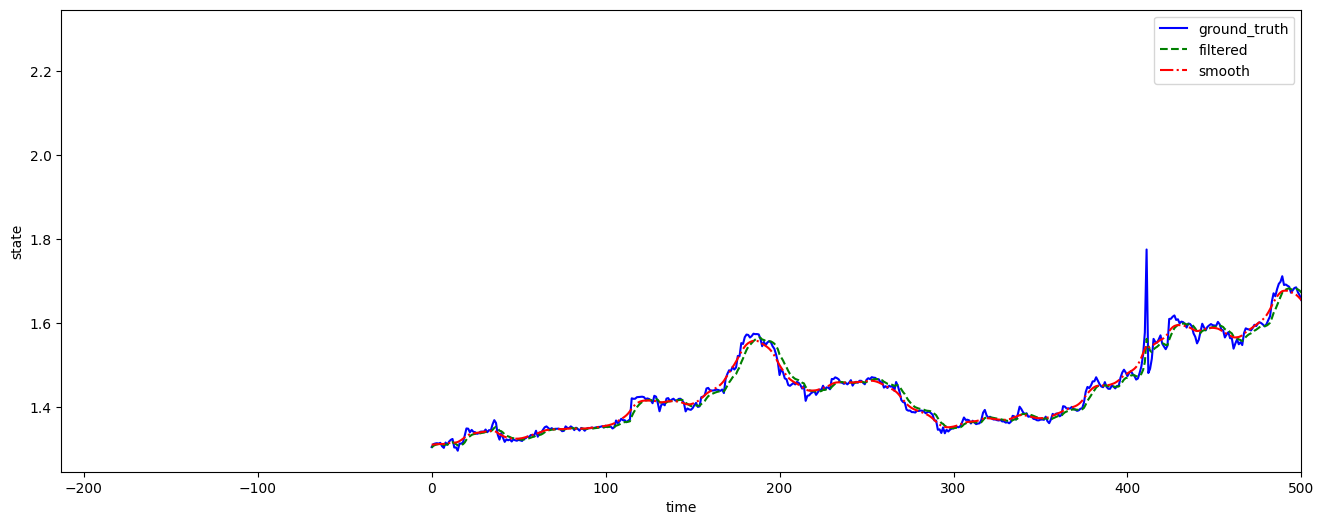

In [12]:
# 1.1 Plots to check Kalman results - these should follow closely!
T = maturities
Q = np.array([[1 - k]])
Z = np.expand_dims(np.exp(-k*T), axis=-1)
transition_covariance = np.array([[sigma**2]])
observation_covariance = 0.001*np.eye(len(T))

kf = pk.KalmanFilter(
    transition_matrices=Q,
    observation_matrices=Z,
    transition_covariance=transition_covariance,
    observation_covariance=observation_covariance,
)

filtered_state_estimates = kf.filter(observations_df)[0]
smoothed_state_estimates = kf.smooth(observations_df)[0]


pylab.figure(figsize=(16, 6))
ground_truth = pylab.plot(observations_df.mean(axis=1),linestyle="-", color="b")
filtered = pylab.plot(filtered_state_estimates,linestyle="--", color="g")
smoothed = pylab.plot(smoothed_state_estimates,linestyle="-.", color="r")
pylab.legend(
    (ground_truth[0], filtered[0], smoothed[0]),
    ("ground_truth", "filtered", "smooth")
)
pylab.xlabel("time")
pylab.ylabel("state")
pylab.xlim(xmax=500)

Note we used hourly data above to get the initial (k, sigma). This was because the minutely fit was bad.
We do not necessarily have to keep to hourly data for the rest of the problem though.

In [37]:
# 2. OU Process for the pricing model.

# Define time series
num_timesteps = 200
t = np.linspace(0, num_timesteps-1, num_timesteps)

# OU Parameters
alpha = -(sigma**2)/(2*k)
dt = np.mean(np.diff(t))


# Initial starting price
y0 = observations_df["log_price_futures"].iloc[-1]

num_sims = 1000

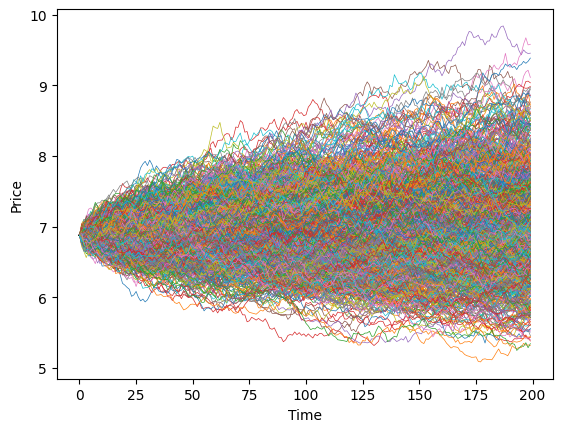

In [38]:
# tmp

def bm_log_rets(dt, sig):
    return np.random.normal(loc=0.0, scale=np.sqrt(dt) * sig, size=num_timesteps)


def ou(num_timesteps, k, alpha, t):
    paths = [y0]
    bm_rets = bm_log_rets(dt, sigma)
    for i in range(1, num_timesteps):
        drift = k*(alpha-paths[i-1])*dt
        rand = bm_rets[i-1]

        path = paths[i-1] + drift + rand
        paths.append(path)
    
    return paths


paths = []
for i in range(num_sims):
    level = ou(num_timesteps, k, alpha, t)
    paths.append(level)
    

paths = np.asarray(paths).T
int_path = np.exp(paths)

plt.plot(int_path, lw=0.5)
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

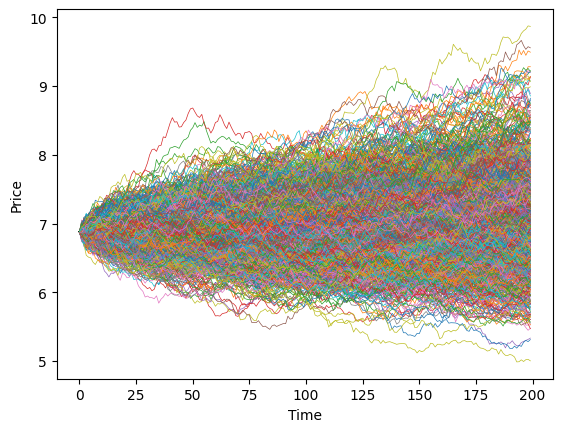

In [48]:
# https://quant.stackexchange.com/questions/32244/geometric-brownian-motion-percentage-returns-vs-log-returns

# This is what we call BrownianMotion().dW()
def bm_log_rets(dt, sig):
    # dW**2 = dt --> dW = sqrt(dt)
    return np.random.normal(loc=0.0, scale=np.sqrt(dt) * sig, size=num_timesteps)


def ou(num_timesteps, k, alpha, t):
    paths = [y0]
    bm_rets = bm_log_rets(dt, sigma)
    
    for i in range(0, num_timesteps-1):
        dX_t = k*(alpha-paths[i])*dt + bm_rets[i]

        # Next = current + difference at timestep t.
        path = paths[i] + dX_t
        paths.append(path)
    
    return paths

    
paths = np.asarray([ou(num_timesteps, k, alpha, t) for _ in range(num_sims)])
int_path = np.exp(paths.T)

plt.plot(int_path, lw=0.5)
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [43]:
np.random.normal(loc=0.0, scale=np.sqrt(dt) * sigma, size=1)

array([-0.00693196])